# ChemEcho Tutorial Notebook
- This code provides step by step instructions for training a model from a SMARTS pattern, evaluating the model, and deploying as a MassQL query
- Other than ChemEcho, must install the MassQL pypi package to last section

## Initial Setup

In [ ]:
# install chemecho
! pip uninstall -y chemecho
! pip install git+https://github.com/biorack/chemecho.git

In [1]:
# imports
from chemecho.utils import load_processed_gnps_data, merge_in_nist
from chemecho.featurization import subformula_featurization, build_feature_matrix, feature_reduction, save_featurized_spectra, load_featurized_spectra, vectorize_spectrum

In [2]:
polarity = 'negative' # either 'negative' or 'positive'
workdir = '/pscratch/sd/t/tharwood/chemecho_tutorial' # storage location for feature matrices, MS2 libraries, etc.

# embedding parameters
vector_assignment_method = 'blur' # either 'blur' or 'top'. blur assigns all subformula within tolerance, top takes only the best one
max_ppm_error = 5 # max ppm error of the subformula assignment
min_feature_occurence = 6 # minimum number of feature occurences to keep

## Download & Process MS2 Training Data (Libraries)

In [3]:
# this function will also download gnps_cleaned if not present at provided path
gnps_cleaned = load_processed_gnps_data(gnps_cleaned_path=f'{workdir}/gnps_cleaned.tsv', convert_spectra=True, polarity=polarity)

# If you have access to commercial NIST library:
merged_lib = merge_in_nist(gnps_cleaned, nist_cleaned_path=f'{workdir}/nist_cleaned.tsv', convert_spectra=True, polarity=polarity)

# if not, uncomment this and remove the line above
# merged_lib = gnps_cleaned

INFO:logger:Cleaned GNPS lib detected, not downloading.


INFO:logger:Converting GNPS json peaks to numpy spectra.


  0%|          | 0/138377 [00:00<?, ?it/s]

INFO:logger:Converting NIST json peaks to numpy spectra.


  0%|          | 0/21604 [00:00<?, ?it/s]

In [4]:
print(f"Total spectra: {merged_lib.shape[0]}")
print(f"Unique InchiKeys: {len(merged_lib.inchikey_smiles.unique())}")

Total spectra: 159981
Unique InchiKeys: 24936


## Build Training Data Feature Matrix

In [5]:
peak_subformula_vectors, nl_subformula_vectors = subformula_featurization(merged_lib, 
                                                                          vector_assignment=vector_assignment_method, 
                                                                          max_ppm_error=max_ppm_error)

  0%|          | 0/159981 [00:00<?, ?row/s]

In [6]:
# get indices of spectra with no subformula assigned
failed_spectra_idxs = [i for i in range(len(peak_subformula_vectors)) if peak_subformula_vectors[i] is None]

In [7]:
featurized_spectral_data, feature_vector_index_map = build_feature_matrix(peak_subformula_vectors, nl_subformula_vectors)

In [8]:
featurized_spectral_data, feature_vector_index_map = feature_reduction(featurized_spectral_data, feature_vector_index_map, 
                                                                       min_occurence=min_feature_occurence)

In [9]:
# save embeddings
save_featurized_spectra(featurized_spectral_data, feature_vector_index_map, failed_spectra_idxs, workdir, 
                        overwrite=False,
                        polarity=polarity)

## Label Data and Train Model

In [10]:
from chemecho.train_predict import train_substructure_tree, filter_failed_idxs

In [11]:
# load embeddings
featurized_spectral_data, feature_vector_index_map, failed_spectra_idxs = load_featurized_spectra(workdir, polarity=polarity)

In [12]:
# filter failed spectra
filtered_spectral_data, filtered_merged_lib = filter_failed_idxs(featurized_spectral_data, merged_lib, failed_spectra_idxs)

In [13]:
# simplistic example for training a model for predicting glucose-derivatives
hexose_smarts = 'OCC1OC(O)C(O)C(O)C1O'

model, report = train_substructure_tree(hexose_smarts, filtered_merged_lib, filtered_spectral_data, workdir, polarity,
                                        frag_type='smarts',
                                        max_depth=3,
                                        min_frag_count=1,
                                        min_positive_unique=10,
                                        save_model=True)

In [14]:
print(f"Precision (True): {report['True']['precision']} \n"
      f"Recall (True): {report['True']['recall']}")

Precision (True): 0.8079567779960707 
Recall (True): 0.43866666666666665


## Display Decision Tree Rules

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

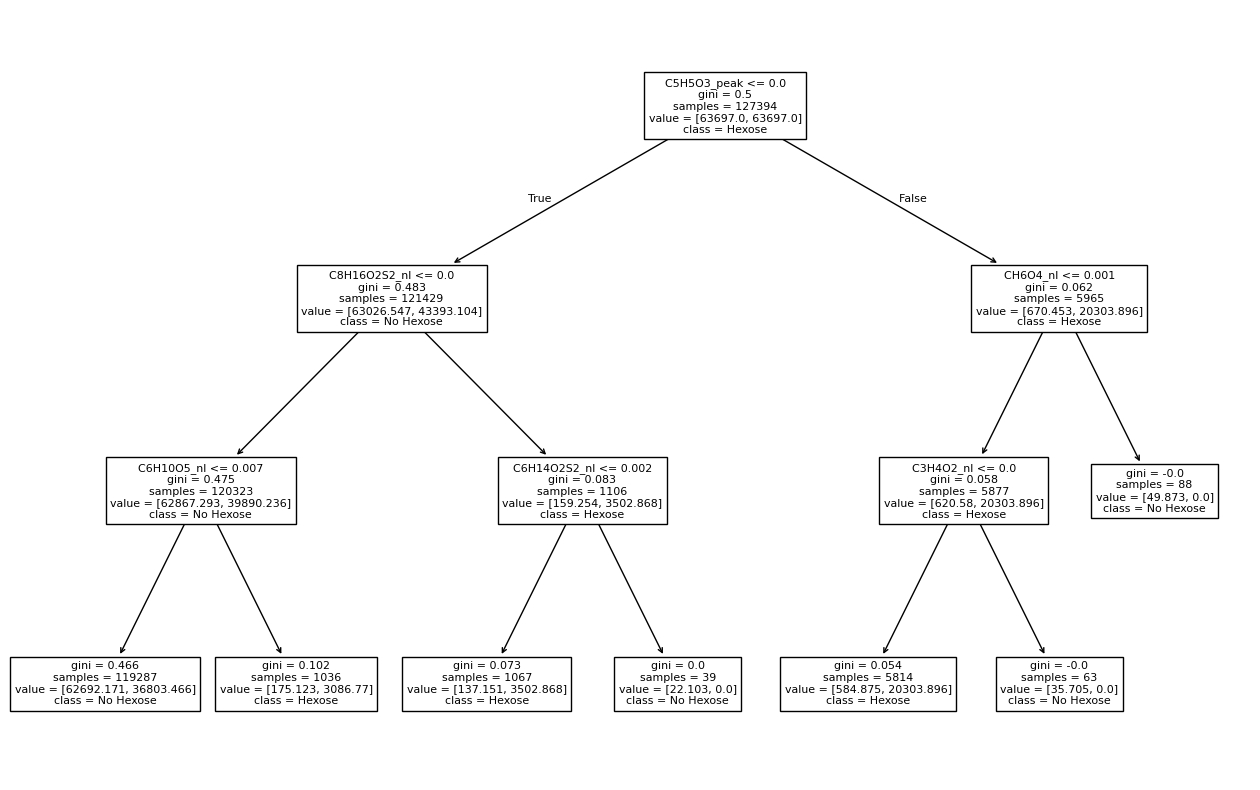

In [16]:
feature_names = list(feature_vector_index_map.keys())
class_names = ['No Hexose', 'Hexose']

fig, ax = plt.subplots(figsize=(16, 10))
plot_tree(model, feature_names=feature_names, class_names=class_names,)
plt.show()

## Predict From New Spectra

In [17]:
import numpy as np
from rdkit.Chem import AllChem
from IPython.display import display

In [18]:
molecule1 = "Glucuronic acid"
smiles1 = "[C@@H]1([C@@H]([C@H](OC([C@@H]1O)O)C(=O)O)O)O"
parent_form1 = 'C6H10O7' # in real cases predicted with SIRIUS/MSBuddy
adduct1 = '[M-H]-' # in real cases either assumed (resulting in predictive penalty) or predicted/empirically determined
precursor_mz1 = 193.035
spectrum1 = np.array([[51.709801,
  57.034199,
  59.013401,
  71.013603,
  71.408501,
  72.992897,
  73.029297,
  73.972702,
  75.008499,
  83.013702,
  85.029404,
  85.035004,
  87.008698,
  89.0243,
  95.013802,
  99.009003,
  101.024002,
  103.003998,
  113.014999,
  113.024002,
  116.607002,
  129.020004,
  131.035004,
  133.014008,
  157.014999,
  163.024994,
  193.035004],
 [55178.199219,
  229171.0,
  2067150.0,
  2229370.0,
  59995.300781,
  5109200.0,
  1023610.0,
  94215.898438,
  87368.898438,
  106567.0,
  2388860.0,
  118491.0,
  91278.398438,
  1230700.0,
  467406.0,
  246487.0,
  1734100.0,
  1689690.0,
  144557.0,
  4421380.0,
  65680.796875,
  248136.0,
  568488.0,
  382782.0,
  295386.0,
  107466.0,
  836176.0]])

Smarts Pattern Used for Training:


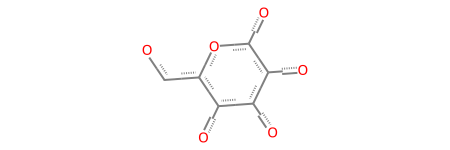

In [19]:
mol = AllChem.MolFromSmarts(hexose_smarts)
print("Smarts Pattern Used for Training:")

display(mol)

Test Molecule Glucuronic acid


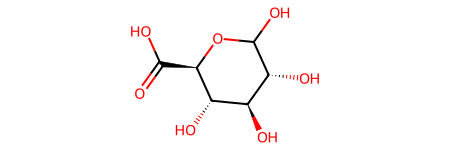

In [20]:
mol = AllChem.MolFromSmiles(smiles1)
print(f"Test Molecule {molecule1}")

display(mol)

In [21]:
ms2_vector = vectorize_spectrum(spectrum1,
                                precursor_mz1,
                                parent_form1,
                                adduct1,
                                feature_vector_index_map,
                                max_ppm_error=5,
                                vector_assignment='blur')

In [22]:
test_pred = model.predict(ms2_vector)
print(f"Prediction using model: {test_pred[0]}")

Prediction using model: True


## Convert Decision Tree into MassQL Rules

In [23]:
from chemecho.train_predict import convert_tree_to_massql

In [24]:
massql_rules = convert_tree_to_massql(model, list(feature_vector_index_map.keys()), positive_class=1, data_type="MS2DATA", tolerance=10, polarity=None, precision=3)

In [25]:
massql_rules

'QUERY scaninfo(MS2DATA) WHERE MS2PROD=formula(C5H5O3):TOLERANCEPPM=10:INTENSITYPERCENT=0.000:EXCLUDED AND MS2NL=formula(C8H16O2S2):TOLERANCEPPM=10:INTENSITYPERCENT=0.000:EXCLUDED AND MS2NL=formula(C6H10O5):TOLERANCEPPM=10:INTENSITYPERCENT=0.007 ||| QUERY scaninfo(MS2DATA) WHERE MS2PROD=formula(C5H5O3):TOLERANCEPPM=10:INTENSITYPERCENT=0.000:EXCLUDED AND MS2NL=formula(C8H16O2S2):TOLERANCEPPM=10:INTENSITYPERCENT=0.000 AND MS2NL=formula(C6H14O2S2):TOLERANCEPPM=10:INTENSITYPERCENT=0.002:EXCLUDED ||| QUERY scaninfo(MS2DATA) WHERE MS2PROD=formula(C5H5O3):TOLERANCEPPM=10:INTENSITYPERCENT=0.000 AND MS2NL=formula(CH6O4):TOLERANCEPPM=10:INTENSITYPERCENT=0.001:EXCLUDED AND MS2NL=formula(C3H4O2):TOLERANCEPPM=10:INTENSITYPERCENT=0.000:EXCLUDED'

## Apply MassQL Rules to Spectra
### This can also be done on GNPS2: [https://gnps2.org/workflowinput?workflowname=massql_workflow]

In [26]:
import pandas as pd
from massql import msql_engine
from massql import msql_fileloading

In [27]:
# load data. Demo data is json, but can use mgf or mzml
ms1_df, ms2_df = msql_fileloading.load_data("demo_spectra.json")
demo_spectra = pd.read_json("demo_spectra.json")

# Apply queries to demo data
all_results = []
for query in massql_rules.split('|||'):
    results_df = msql_engine.process_query(query, "demo_spectra.json", ms1_df=ms1_df, ms2_df=ms2_df, path_to_grammar=None)
    all_results.append(results_df)

all_results = pd.concat(all_results)
all_results = pd.merge(all_results, demo_spectra.rename(columns={'spectrum_id':'scan'}), on='scan')

100%|██████████| 14/14 [00:00<00:00, 1275.03it/s]


TOTAL QUERIES 1


100%|██████████| 1/1 [00:00<00:00, 77.55it/s]


parsed_dict {
    "querytype": {
        "function": "functionscaninfo",
        "datatype": "datams2data"
    },
    "conditions": [
        {
            "type": "ms2productcondition",
            "value": [
                113.02386901903
            ],
            "conditiontype": "where",
            "qualifiers": {
                "type": "qualifier",
                "qualifierppmtolerance": {
                    "name": "qualifierppmtolerance",
                    "unit": "ppm",
                    "value": 10.0
                },
                "qualifierintensitypercent": {
                    "name": "qualifierintensitypercent",
                    "value": 0.0
                },
                "qualifierexcluded": {
                    "name": "qualifierexcluded"
                }
            }
        },
        {
            "type": "ms2neutrallosscondition",
            "value": [
                208.05917175224
            ],
            "conditiontype": "where",
     

100%|██████████| 1/1 [00:00<00:00, 284.17it/s]


parsed_dict {
    "querytype": {
        "function": "functionscaninfo",
        "datatype": "datams2data"
    },
    "conditions": [
        {
            "type": "ms2productcondition",
            "value": [
                113.02386901903
            ],
            "conditiontype": "where",
            "qualifiers": {
                "type": "qualifier",
                "qualifierppmtolerance": {
                    "name": "qualifierppmtolerance",
                    "unit": "ppm",
                    "value": 10.0
                },
                "qualifierintensitypercent": {
                    "name": "qualifierintensitypercent",
                    "value": 0.0
                },
                "qualifierexcluded": {
                    "name": "qualifierexcluded"
                }
            }
        },
        {
            "type": "ms2neutrallosscondition",
            "value": [
                208.05917175224
            ],
            "conditiontype": "where",
     

100%|██████████| 1/1 [00:00<00:00, 565.96it/s]

parsed_dict {
    "querytype": {
        "function": "functionscaninfo",
        "datatype": "datams2data"
    },
    "conditions": [
        {
            "type": "ms2productcondition",
            "value": [
                113.02386901903
            ],
            "conditiontype": "where",
            "qualifiers": {
                "type": "qualifier",
                "qualifierppmtolerance": {
                    "name": "qualifierppmtolerance",
                    "unit": "ppm",
                    "value": 10.0
                },
                "qualifierintensitypercent": {
                    "name": "qualifierintensitypercent",
                    "value": 0.0
                }
            }
        },
        {
            "type": "ms2neutrallosscondition",
            "value": [
                82.02660867066
            ],
            "conditiontype": "where",
            "qualifiers": {
                "type": "qualifier",
                "qualifierppmtolerance": {
    

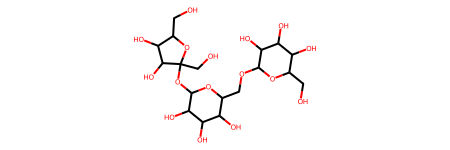

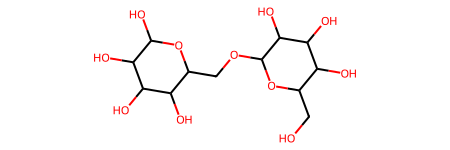

In [28]:
# display retrieved structures
for smiles in all_results.smiles.tolist():
    mol = AllChem.MolFromSmiles(smiles)
    display(mol)